In [1]:
import importlib
import library.nbtool as nbtool; importlib.reload(nbtool)
import parser.lycee as lycee;    importlib.reload(lycee)
from parser.lycee import *

sorted collection imported


# Read the dataset and construct the multi stream graph

In [2]:
Lycee = MultiStream(interval, LYCEE, LayerList([]), LinkList([]))
liste, liste2 = readNodes(Lycee, ["face_to_face", "facebook", "friendship"])
ti, ni = readLinks(Lycee, liste)
readLinks2(Lycee, liste, liste2)   # read facebook links
readLinks3(Lycee, liste, liste2)   # read friendship links

readlink2...
readlink3...
link3 done


## Various types of layer definitions

In [3]:
_math_physics = layerWithCommonPoint(LYCEE, "annee", "MP")
MathPhysics = Lycee.extractLayers(_math_physics)

_girls, _boys = [layerWithCommonPoint(LYCEE, 'sexe', sexe) for sexe in ['F', 'M']]
Girls   = Lycee.extractLayers(_girls)
Boys    = Lycee.extractLayers(_boys)
UniSex  = Lycee.interLayers(_girls, _boys)

_f2f = layerWithCommonPoint(LYCEE, "typeOfRel", "face_to_face")  # face to face layer
F2F     = Lycee.extractLayers(_f2f)

## Cut the Multi-layer stream graph (MLSG) in a window of time

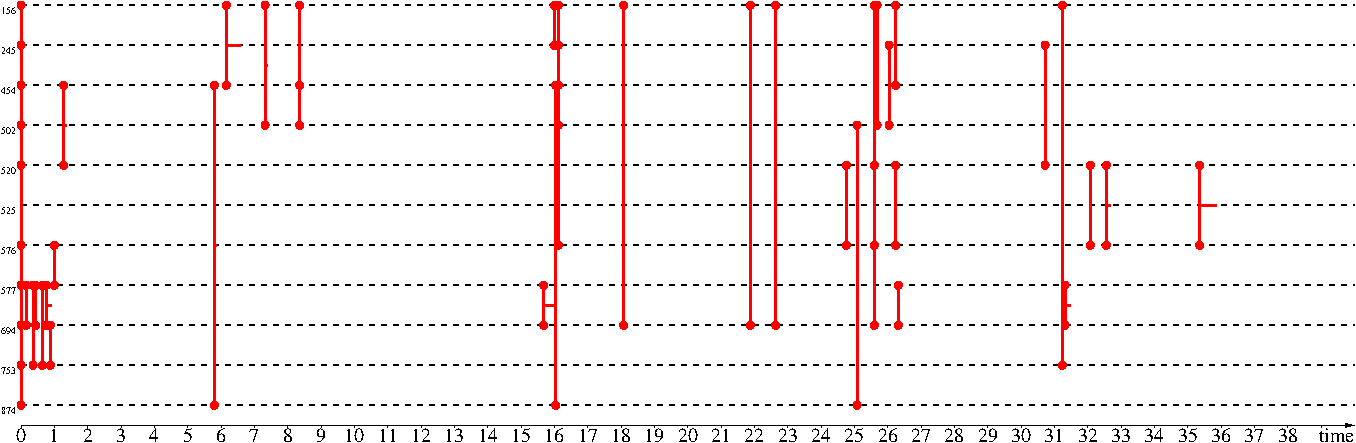

/Users/wakita/Dropbox/projects/mxvis/mx-streams/src/outputs/mp_girls.png

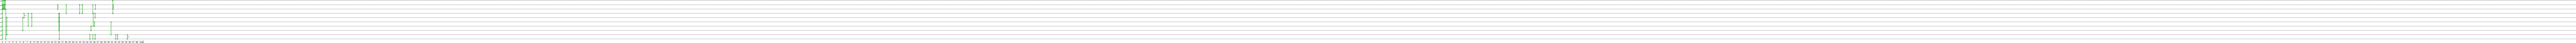

/Users/wakita/Dropbox/projects/mxvis/mx-streams/src/outputs/mp_girls_ordonne.png

In [4]:
# Face to face relationship among girls taking Math & Physics during the period [0, 40]
layers1 = Lycee.cut(Interval(0, 40)).extractLayers(_math_physics).extractLayers(_girls).extractLayers(_f2f)

nbtool.drawMS(layers1, name='mp_girls', show=True)
nbtool.drawMS(layers1, name='mp_girls_ordonne', show=True, ordonne=True)

## Bug

`mp_firls_ordonne.fig` is a bit broken.  Somehow when `ordonne=True` is specified the drawMS seem to resets the interval.  This is not the case with Pimprenelle's original implementation.  I think this is due to inappropriate implicit reference of a global variable in my implementation.